In [1]:
import SimpleITK as sitk
import os
import nibabel as nib
# import pandas as pd

from matplotlib import pyplot as plt

from dltk.io.augmentation import *
from dltk.io.preprocessing import *

ModuleNotFoundError: No module named 'SimpleITK'

In [28]:
path1 = 'DATA/alff/ASD/Caltech_0051456_alff.nii.gz'
path2 = 'DATA/degree_binarize/ASD/Caltech_0051456_degree_binarize.nii.gz' 

sitk_t1 = sitk.ReadImage(path1)
t1 = sitk.GetArrayFromImage(sitk_t1)
t1.shape

(61, 73, 61)

In [29]:
# import nibabel as nib

# img = nib.load(path)
# arr = img.get_fdata()
# print(arr.shape)
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.imshow(arr[:,:,31], cmap='gray')
# plt.colorbar()
# plt.plot()


In [30]:
# Normalise the image to zero mean/unit std dev using volume statistics:
t1_white = whitening(t1)

# Normalise the image to fit [0, 1] range:
t1_norm_zo = normalise_zero_one(t1)

# Normalise the image to fit [-1, 1] range:
t1_norm_oo = normalise_one_one(t1)

(73, 61)


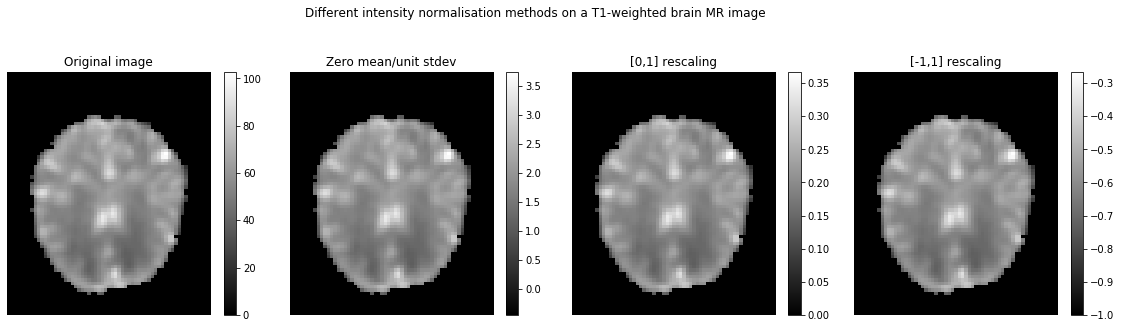

In [31]:

# Visualise using matplotlib.
center_slices = [s//2 for s in t1.shape]
print(np.squeeze(t1[center_slices[0], :, :]).shape)


f, axarr = plt.subplots(1, 4, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on a T1-weighted brain MR image')

img = axarr[0].imshow(np.squeeze(t1[center_slices[0], :, :]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(t1_white[center_slices[0], :, :]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(t1_norm_zo[center_slices[0], :, :]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('[0,1] rescaling')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(t1_norm_oo[center_slices[0], :, : ]), cmap='gray');
axarr[3].axis('off')
axarr[3].set_title('[-1,1] rescaling')
f.colorbar(img, ax=axarr[3])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();



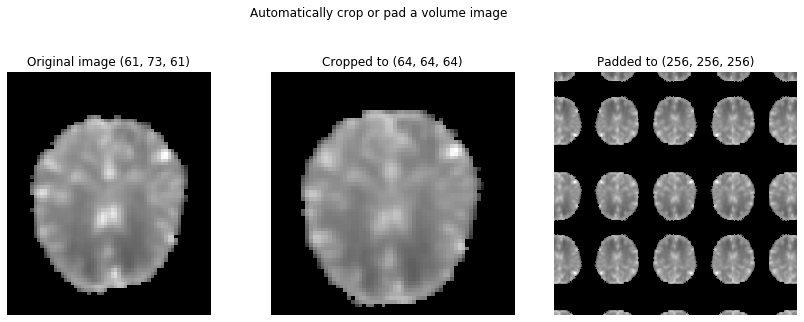

In [33]:


# Crop to [64, 64, 64]
t1_cropped = resize_image_with_crop_or_pad(t1, [64, 64, 64], mode='symmetric')

# Resizing image to [128, 256, 256] required padding
t1_padded = resize_image_with_crop_or_pad(t1, [256, 256, 256], mode='symmetric')

# Visualise using matplotlib.
f, axarr = plt.subplots(1, 3, figsize=(15,5));
f.suptitle('Automatically crop or pad a volume image')

axarr[0].imshow(np.squeeze(t1[t1.shape[0]//2, :, :]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image {}'.format(t1.shape))

axarr[1].imshow(np.squeeze(t1_cropped[t1_cropped.shape[0]//2, :, :]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Cropped to {}'.format(t1_cropped.shape))

axarr[2].imshow(np.squeeze(t1_padded[t1_padded.shape[0]//2, :, :]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('Padded to {}'.format(t1_padded.shape))
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();



In [6]:
# For demo purposes, extract a 2D slice from the image volume. This is just to better
# demonstrate the Gaussian offset augmentation. To demonstrate, that this works on 
# volumes, we ensure that the slice is a 3D volume: 
center_slices = [s//2 for s in t1.shape]
print(center_slices)

t1_slice = t1[:, :, :].copy()
print(t1_slice.shape)

# Add a feature dimension and normalise
t1_norm = np.expand_dims(normalise_one_one(t1_slice), axis=-1)

# Randomly flip the image along axis 1
t1_flipped = flip(t1_norm.copy(), axis=2)

# Add a Gaussian offset (independently for each channel)
t1_offset = add_gaussian_offset(t1_norm.copy(), sigma=0.6)

# Add Gaussian noise
t1_noise = add_gaussian_noise(t1_norm.copy(), sigma=0.1)

# Elastic transforms according to:
# [1] Simard, Steinkraus and Platt, "Best Practices for Convolutional
#     Neural Networks applied to Visual Document Analysis", in Proc. of the
#     International Conference on Document Analysis and Recognition, 2003.
t1_trans_low_s = elastic_transform(t1_norm.copy(), alpha=[1e5, 1e5, 1e5, 1], sigma=[15, 15, 15, 1])
t1_trans_high_s = elastic_transform(t1_norm.copy(), alpha=[2e6, 2e6, 2e6, 1], sigma=[25, 25, 25, 1])

[30, 36, 30]
(61, 73, 61)


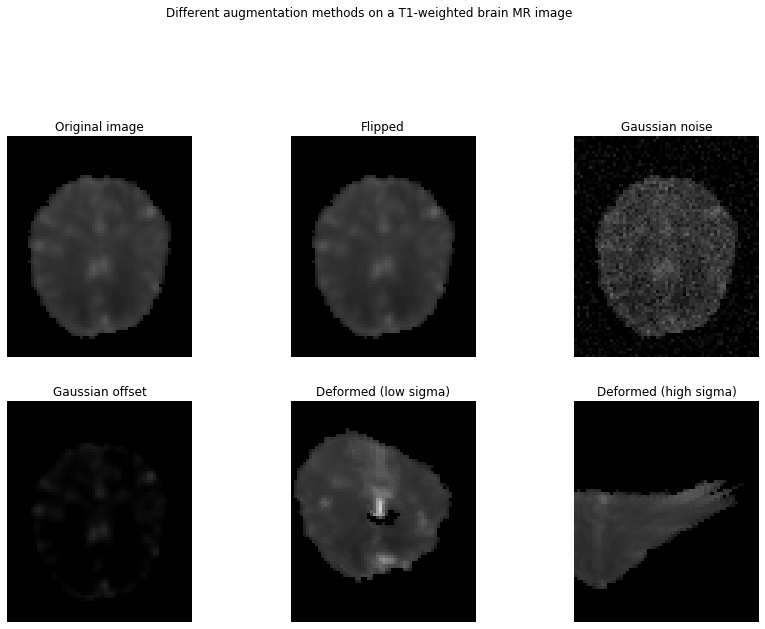

In [7]:
# Visualise using matplotlib
f, axarr = plt.subplots(2, 3, figsize=(15,10));
f.suptitle('Different augmentation methods on a T1-weighted brain MR image')

axarr[0,0].imshow(np.squeeze(t1_norm[center_slices[0]:center_slices[0]+1,:,:]), cmap='gray', vmin=-1, vmax=1);
axarr[0,0].axis('off')
axarr[0,0].set_title('Original image')

axarr[0,1].imshow(np.squeeze(t1_flipped[center_slices[0]:center_slices[0]+1,:,:]), cmap='gray', vmin=-1, vmax=1);
axarr[0,1].axis('off')
axarr[0,1].set_title('Flipped')

axarr[0,2].imshow(np.squeeze(t1_noise[center_slices[0]:center_slices[0]+1,:,:]), cmap='gray', vmin=-1, vmax=1);
axarr[0,2].axis('off')
axarr[0,2].set_title('Gaussian noise')

axarr[1,0].imshow(np.squeeze(t1_offset[center_slices[0]:center_slices[0]+1,:,:]), cmap='gray', vmin=-1, vmax=1);
axarr[1,0].axis('off')
axarr[1,0].set_title('Gaussian offset')

axarr[1,1].imshow(np.squeeze(t1_trans_low_s[center_slices[0]:center_slices[0]+1,:,:]), cmap='gray', vmin=-1, vmax=1);
axarr[1,1].axis('off')
axarr[1,1].set_title('Deformed (low sigma)')

axarr[1,2].imshow(np.squeeze(t1_trans_high_s[center_slices[0]:center_slices[0]+1,:,:]), cmap='gray', vmin=-1, vmax=1);
axarr[1,2].axis('off')
axarr[1,2].set_title('Deformed (high sigma)')
    
f.subplots_adjust(wspace=0.05, top=0.8)
plt.show();